In [24]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score

from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential


In [25]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1777360 entries, 0 to 1777359
Columns: 113 entries, userID_hash to y
dtypes: float64(111), object(2)
memory usage: 1.5+ GB


In [27]:
train.info(verbose=False, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1777360 entries, 0 to 1777359
Columns: 113 entries, userID_hash to y
dtypes: float64(111), object(2)
memory usage: 1.7 GB


In [28]:
start_mem = train.memory_usage().sum() / 1024**2

In [29]:
print(start_mem)

1532.3005409240723


# reduce memory

In [16]:
def reduce_mem_usage(train, verbose=True):

    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = train.memory_usage().sum() / 1024**2

    for col in train.columns:
        col_type = train[col].dtypes
        if col_type in numerics:
            c_min = train[col].min()
            c_max = train[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    train[col] = train[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    train[col] = train[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    train[col] = train[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    train[col] = train[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    train[col] = train[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    train[col] = train[col].astype(np.float32)
                else:
                    train[col] = train[col].astype(np.float64)

    end_mem = train.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return train

In [30]:
train = reduce_mem_usage(train)

Memory usage after optimization is: 542.41 MB
Decreased by 64.6%


In [18]:
print("Training shape: ", train.shape)

Training shape:  (1777360, 114)


In [31]:
train.head()

,userID_hash,month,x0,x1,x2,x3,x4,x5,x6,x7,...,previous_x46,previous_x47,previous_x48,previous_x49,previous_x50,previous_x51,previous_x52,previous_x53,previous_x54,y
0,2d90a44b2d37900619c2398ee3b07c24ae45c9436fb44b...,2022-09,4.000000,4.0,0.0,2.0,2.0,0.0,138000.0,0.0,...,0.0,2.0,2.0,0.0,61000.0,0.0,30500.0,0.0,1.0,177000.0
1,097a3239adb67f3d00fe75338a7e1082363746384dff00...,2022-07,2.091797,11.0,1.0,8.0,8.0,1.0,7087542.0,750000.0,...,0.0,1.0,1.0,0.0,180300.0,0.0,90150.0,0.0,1.0,14893793.0
2,9f9f56fdc788f9a817ec9928309921539a47f6656fe7d6...,2022-07,9.335938,4.0,0.0,3.0,3.0,0.0,267050.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,232200.0
3,b5ccb95b3a44bc48b5d8bd819cf48689f756c5c2669619...,2022-10,0.500000,19.0,4.0,7.0,7.0,1.0,1756880.0,453000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410200.0
4,afd48246a21834776f945fc30e10ea7bba1d051b01798d...,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105000.0


In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1777360 entries, 0 to 1777359
Columns: 113 entries, userID_hash to y
dtypes: float16(70), float32(41), object(2)
memory usage: 542.4+ MB


In [33]:
train['y'].describe()

count    1.777360e+06
mean     7.118294e+05
std      2.623770e+06
min      0.000000e+00
25%      2.000000e+04
50%      1.545000e+05
75%      6.030000e+05
max      5.100227e+08
Name: y, dtype: float64

In [34]:
(train['y'] == 0).sum()

209701

In [35]:
train['month'].value_counts()

month
2022-10    389568
2022-09    370634
2022-11    363122
2022-08    341029
2022-07    313007
Name: count, dtype: int64

In [36]:
# get average of y for each month
train['y'].groupby(train['month']).mean()

month
2022-07    744078.3750
2022-08    680507.0000
2022-09    682856.1875
2022-10    707302.6250
2022-11    747877.0000
Name: y, dtype: float32

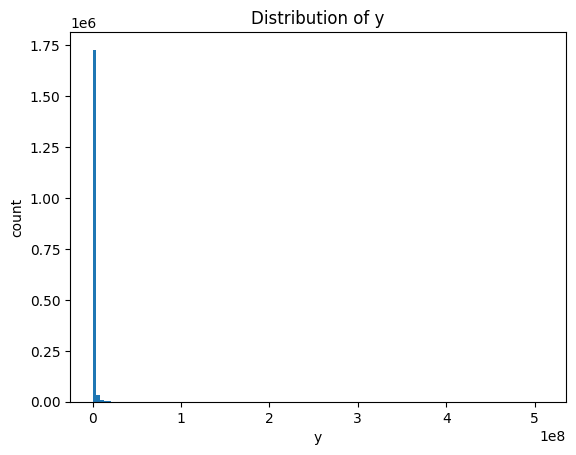

In [37]:
# plot y distribution in train
plt.hist(train['y'], bins=120)
plt.title('Distribution of y')
plt.xlabel('y')
plt.ylabel('count')
plt.show()

In [38]:
train['userID_hash'].value_counts().value_counts()

count
1    1376372
2     176403
3      15111
4        696
5         13
Name: count, dtype: int64

In [39]:
test['month'].value_counts()

month
2022-12    362946
Name: count, dtype: int64

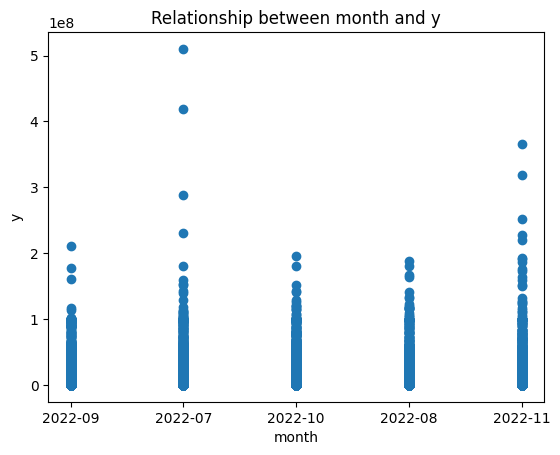

In [40]:
# plot show relationship between month and y
plt.scatter(train['month'], train['y'])
plt.title('Relationship between month and y')
plt.xlabel('month')
plt.ylabel('y')
plt.show()

In [41]:
missing_70more_cols = []
for col in train.columns:
    missing_ratio = train[col].isnull().sum()/len(train)
    if  missing_ratio > 0.7:
        print('Columns: {} - Missing value ratio: {}'.format(col, missing_ratio))
        missing_70more_cols.append(col)
    # else:
    #     print(col)

Columns: x33 - Missing value ratio: 0.8307000270063465
Columns: x34 - Missing value ratio: 0.7355763604447045
Columns: x35 - Missing value ratio: 0.7355763604447045
Columns: x36 - Missing value ratio: 0.7355763604447045
Columns: x37 - Missing value ratio: 0.7355763604447045
Columns: x38 - Missing value ratio: 0.7355763604447045
Columns: x39 - Missing value ratio: 0.7355763604447045
Columns: x40 - Missing value ratio: 0.7355763604447045
Columns: x41 - Missing value ratio: 0.7355763604447045
Columns: x42 - Missing value ratio: 0.7355763604447045
Columns: x43 - Missing value ratio: 0.7355763604447045
Columns: previous_x11 - Missing value ratio: 0.7320587838141963
Columns: previous_x33 - Missing value ratio: 0.8296349642165909
Columns: previous_x34 - Missing value ratio: 0.7360163388396274
Columns: previous_x35 - Missing value ratio: 0.7360163388396274
Columns: previous_x36 - Missing value ratio: 0.7360163388396274
Columns: previous_x37 - Missing value ratio: 0.7360163388396274
Columns: pr

In [43]:
train

,userID_hash,month,x0,x1,x2,x3,x4,x5,x6,x7,...,previous_x46,previous_x47,previous_x48,previous_x49,previous_x50,previous_x51,previous_x52,previous_x53,previous_x54,y
0,2d90a44b2d37900619c2398ee3b07c24ae45c9436fb44b...,2022-09,4.000000,4.0,0.0,2.0,2.0,0.0,138000.0,0.0,...,0.0,2.0,2.0,0.0,61000.0,0.0,30500.0,0.0,1.0,177000.0
1,097a3239adb67f3d00fe75338a7e1082363746384dff00...,2022-07,2.091797,11.0,1.0,8.0,8.0,1.0,7087542.0,750000.0,...,0.0,1.0,1.0,0.0,180300.0,0.0,90150.0,0.0,1.0,14893793.0
2,9f9f56fdc788f9a817ec9928309921539a47f6656fe7d6...,2022-07,9.335938,4.0,0.0,3.0,3.0,0.0,267050.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,232200.0
3,b5ccb95b3a44bc48b5d8bd819cf48689f756c5c2669619...,2022-10,0.500000,19.0,4.0,7.0,7.0,1.0,1756880.0,453000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410200.0
4,afd48246a21834776f945fc30e10ea7bba1d051b01798d...,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1777355,cfeb70397779fdcaeefcdc72a5211a0d8861eab7b4b0aa...,2022-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20000.0
1777356,2e98ff188fb794d4b4d4dbe5025c3e0ddad5b1c912a593...,2022-09,1.000000,2.0,0.0,2.0,2.0,0.0,20000.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000.0
1777357,d2727d52f9a0cdf020995485f8a91b130bdbe71281bade...,2022-10,0.399902,6.0,0.0,2.0,2.0,0.0,129000.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65000.0
1777358,7e585db8ef31d0a79ab5aeaea677b5728249b7e9ac3707...,2022-10,NaN,1.0,0.0,1.0,1.0,0.0,980.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115296.0


In [44]:
train.drop(['userID_hash'],axis=1,inplace=True)

In [ ]:
train.drop(['userID_hash'],axis=1,inplace=True)

# preprocessing

In [45]:
# train.iloc[:,:-1].corr()

ValueError: could not convert string to float: '2022-09'

In [ ]:
# dt = train[['y', 'previous_x50']]

In [4]:
dt = train.drop(['userID_hash'], axis = 1)

In [5]:
train[['year', 'month']] = train['month'].str.split('-', expand=True)

In [7]:
train.fillna(-999)

,userID_hash,month,x0,x1,x2,x3,x4,x5,x6,x7,...,previous_x47,previous_x48,previous_x49,previous_x50,previous_x51,previous_x52,previous_x53,previous_x54,y,year
0,2d90a44b2d37900619c2398ee3b07c24ae45c9436fb44b...,09,4.000000,4.0,0.0,2.0,2.0,0.0,138000.0,0.0,...,2.0,2.0,0.0,61000.0,0.0,30500.0,0.0,1.0,177000.0,2022
1,097a3239adb67f3d00fe75338a7e1082363746384dff00...,07,2.090909,11.0,1.0,8.0,8.0,1.0,7087542.0,750000.0,...,1.0,1.0,0.0,180300.0,0.0,90150.0,0.0,1.0,14893793.0,2022
2,9f9f56fdc788f9a817ec9928309921539a47f6656fe7d6...,07,9.333333,4.0,0.0,3.0,3.0,0.0,267050.0,0.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,232200.0,2022
3,b5ccb95b3a44bc48b5d8bd819cf48689f756c5c2669619...,10,0.500000,19.0,4.0,7.0,7.0,1.0,1756880.0,453000.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,410200.0,2022
4,afd48246a21834776f945fc30e10ea7bba1d051b01798d...,10,-999.000000,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,105000.0,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1777355,cfeb70397779fdcaeefcdc72a5211a0d8861eab7b4b0aa...,09,-999.000000,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,20000.0,2022
1777356,2e98ff188fb794d4b4d4dbe5025c3e0ddad5b1c912a593...,09,1.000000,2.0,0.0,2.0,2.0,0.0,20000.0,0.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,10000.0,2022
1777357,d2727d52f9a0cdf020995485f8a91b130bdbe71281bade...,10,0.400000,6.0,0.0,2.0,2.0,0.0,129000.0,0.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,65000.0,2022
1777358,7e585db8ef31d0a79ab5aeaea677b5728249b7e9ac3707...,10,-999.000000,1.0,0.0,1.0,1.0,0.0,980.0,0.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,115296.0,2022


In [ ]:
is_na = dt.isna().sum()

In [ ]:
data = []
for i in is_na.index:
    if is_na[i] > 0:
        data.append(i)
print(data)

['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'previous_x0', 'previous_x1', 'previous_x2', 'previous_x3', 'previous_x4', 'previous_x5', 'previous_x6', 'previous_x7', 'previous_x8', 'previous_x9', 'previous_x10', 'previous_x11', 'previous_x12', 'previous_x13', 'previous_x14', 'previous_x15', 'previous_x16', 'previous_x17', 'previous_x18', 'previous_x19', 'previous_x20', 'previous_x21', 'previous_x22', 'previous_x23', 'previous_x24', 'previous_x25', 'previous_x26', 'previous_x27', 'previous_x28', 'previous_x29', 'previous_x30', 'previous_x31', 'previous_x32', 'previous_x33', 'previous_x34', 'previous_x35', 'previous_x36', 'previous_x37', 'previous_x38', 'previous_

In [ ]:
dt_fill = dt.fillna(method='ffill').fillna(method='bfill')

C:\Users\ductr\AppData\Local\Temp\ipykernel_28120\4157977203.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dt_fill = dt.fillna(method='ffill')


In [255]:
dt_fill.head()

,month,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,previous_x47,previous_x48,previous_x49,previous_x50,previous_x51,previous_x52,previous_x53,previous_x54,y,year
0,09,4.000000,4.0,0.0,2.0,2.0,0.0,138000.0,0.0,34500.000,...,2.0,2.0,0.0,61000.0,0.0,30500.0,0.0,1.0,177000.0,2022
1,07,2.090909,11.0,1.0,8.0,8.0,1.0,7087542.0,750000.0,590628.500,...,1.0,1.0,0.0,180300.0,0.0,90150.0,0.0,1.0,14893793.0,2022
2,07,9.333333,4.0,0.0,3.0,3.0,0.0,267050.0,0.0,66762.500,...,1.0,1.0,0.0,180300.0,0.0,90150.0,0.0,1.0,232200.0,2022
3,10,0.500000,19.0,4.0,7.0,7.0,1.0,1756880.0,453000.0,76386.086,...,1.0,1.0,0.0,180300.0,0.0,90150.0,0.0,1.0,410200.0,2022
4,10,0.500000,19.0,4.0,7.0,7.0,1.0,1756880.0,453000.0,76386.086,...,1.0,1.0,0.0,180300.0,0.0,90150.0,0.0,1.0,105000.0,2022


In [260]:
is_nan=dt_fill.isna().sum()

In [262]:
data_1 = []
for i in is_nan.index:
    if is_nan[i] > 0:
        data_1.append(i)
print(data_1)

['x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'previous_x33', 'previous_x34', 'previous_x35', 'previous_x36', 'previous_x37', 'previous_x38', 'previous_x39', 'previous_x40', 'previous_x41', 'previous_x42', 'previous_x43']


In [195]:
data = dt.interpolate()

C:\Users\ductr\AppData\Local\Temp\ipykernel_28120\3576530043.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = dt.interpolate()


In [196]:
data.head()

,month,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,previous_x47,previous_x48,previous_x49,previous_x50,previous_x51,previous_x52,previous_x53,previous_x54,y,year
0,09,4.000000,4.0,0.0,2.0,2.0,0.0,138000.0,0.0,34500.000,...,2.0,2.0,0.0,61000.0,0.0,30500.00,0.0,1.0,177000.0,2022
1,07,2.090909,11.0,1.0,8.0,8.0,1.0,7087542.0,750000.0,590628.500,...,1.0,1.0,0.0,180300.0,0.0,90150.00,0.0,1.0,14893793.0,2022
2,07,9.333333,4.0,0.0,3.0,3.0,0.0,267050.0,0.0,66762.500,...,1.4,1.4,0.0,505223.0,0.0,162365.75,0.0,1.0,232200.0,2022
3,10,0.500000,19.0,4.0,7.0,7.0,1.0,1756880.0,453000.0,76386.086,...,1.8,1.8,0.0,830146.0,0.0,234581.50,0.0,1.0,410200.0,2022
4,10,3.250000,10.5,2.0,4.5,4.5,0.5,1240750.0,226500.0,219348.043,...,2.2,2.2,0.0,1155069.0,0.0,306797.25,0.0,1.0,105000.0,2022


In [197]:
data.isna().sum()

month           0
x0              0
x1              0
x2              0
x3              0
               ..
previous_x52    0
previous_x53    0
previous_x54    0
y               0
year            0
Length: 113, dtype: int64

In [198]:
data.drop(['year'], axis =  1, inplace=True)

In [199]:
dt_cr = data.corr()

In [127]:
# import seaborn as sns
# sns.heatmap(dt)

In [128]:
dt_cr.head()

,month,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,previous_x46,previous_x47,previous_x48,previous_x49,previous_x50,previous_x51,previous_x52,previous_x53,previous_x54,y
month,1.000000,-0.037993,0.006870,0.002134,-0.011399,-0.011656,0.006694,0.001326,0.001184,-0.000038,...,-0.041991,-0.010853,-0.007868,-0.058440,0.020340,-0.019364,0.038010,-0.017446,0.042982,0.002304
x0,-0.037993,1.000000,-0.154549,-0.086340,-0.120357,-0.119229,-0.108257,-0.001757,-0.006251,0.015679,...,-0.006919,-0.128300,-0.128384,-0.007913,-0.073419,-0.004446,-0.047516,-0.000096,-0.003491,-0.042220
x1,0.006870,-0.154549,1.000000,0.215506,0.687310,0.695710,0.272375,0.134086,0.138636,0.028534,...,0.031259,0.441043,0.441118,0.038327,0.257551,0.018030,-0.020195,-0.001795,0.005937,0.240748
x2,0.002134,-0.086340,0.215506,1.000000,0.242690,0.125212,0.766013,0.029867,0.094979,-0.018904,...,0.042763,0.057216,0.056016,0.036431,0.035997,0.017845,-0.009936,0.012926,-0.030996,0.025979
x3,-0.011399,-0.120357,0.687310,0.242690,1.000000,0.980493,0.345495,0.009260,0.021295,-0.028199,...,0.022758,0.593517,0.593798,0.033583,0.187741,0.009512,-0.056344,-0.003733,0.010104,0.193882


In [200]:
result = dt_cr[dt_cr['y'] > 0.3]

In [201]:
result.reset_index()

,index,month,x0,x1,x2,x3,x4,x5,x6,x7,...,previous_x46,previous_x47,previous_x48,previous_x49,previous_x50,previous_x51,previous_x52,previous_x53,previous_x54,y
0,x28,-0.000766,-0.050002,0.305388,0.047553,0.239034,0.243888,0.076673,0.008854,0.016590,...,0.005590,0.116194,0.116327,0.009423,0.374888,0.049447,0.173659,0.015472,0.004815,0.599854
1,x39,0.001601,-0.021644,0.074456,0.008071,0.071201,0.075313,0.016879,0.003039,0.007719,...,-0.000787,0.008731,0.008819,0.000821,0.034489,0.001851,0.023421,0.001318,0.001085,0.312657
2,x50,0.008937,-0.055077,0.305084,0.038975,0.200688,0.203785,0.060591,0.007827,0.011638,...,0.007052,0.166985,0.167246,0.010622,0.528294,0.066484,0.239051,0.019138,0.006890,0.365640
3,previous_x28,-0.000619,-0.038729,0.189019,0.023908,0.162384,0.165375,0.046463,0.005391,0.009122,...,0.015649,0.194187,0.194308,0.020442,0.632388,0.070104,0.306419,0.019879,0.009479,0.503961
4,y,0.002304,-0.032133,0.195573,0.021305,0.159002,0.163808,0.038941,0.004928,0.009564,...,0.004283,0.093949,0.094062,0.006338,0.289138,0.039744,0.144995,0.014397,0.004780,1.000000


In [202]:
index = []
for i in result.index:
    index.append(i)
print(index)

['x28', 'x39', 'x50', 'previous_x28', 'y']


In [203]:
df = data[index]

In [204]:
df.shape

(1777360, 5)

In [205]:
df.head()

,x28,x39,x50,previous_x28,y
0,69000.0,NaN,6.900000e+04,61000.0,177000.0
1,5487542.0,3.720542e+06,1.767000e+06,9353167.0,14893793.0
2,267050.0,2.670500e+05,1.373940e+06,7843516.6,232200.0
3,980880.0,4.195733e+05,9.808800e+05,6333866.2,410200.0
4,852750.0,5.720967e+05,1.354722e+06,4824215.8,105000.0


In [135]:
df['month'] = dt['month']

C:\Users\ductr\AppData\Local\Temp\ipykernel_28120\222916567.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = dt['month']


In [136]:
df.isna().sum()

x28              662434
x30              662434
x39             1307384
x41             1307384
x50              926935
previous_x28     763634
previous_x30     763634
previous_x39    1308166
previous_x41    1308166
previous_x50    1027696
y                     0
month                 0
dtype: int64

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1777360 entries, 0 to 1777359
Data columns (total 12 columns):
 #   Column        Dtype  
---  ------        -----  
 0   x28           float64
 1   x30           float64
 2   x39           float64
 3   x41           float64
 4   x50           float64
 5   previous_x28  float64
 6   previous_x30  float64
 7   previous_x39  float64
 8   previous_x41  float64
 9   previous_x50  float64
 10  y             float64
 11  month         object 
dtypes: float64(11), object(1)
memory usage: 162.7+ MB


In [138]:
df.isna().sum()

x28              662434
x30              662434
x39             1307384
x41             1307384
x50              926935
previous_x28     763634
previous_x30     763634
previous_x39    1308166
previous_x41    1308166
previous_x50    1027696
y                     0
month                 0
dtype: int64

In [139]:
df.head()

,x28,x30,x39,x41,x50,previous_x28,previous_x30,previous_x39,previous_x41,previous_x50,y,month
0,69000.0,34500.00,NaN,NaN,69000.0,61000.0,30500.0,NaN,NaN,61000.0,177000.0,09
1,5487542.0,609726.90,3720542.0,744108.4,1767000.0,9353167.0,935316.7,9172867.0,1146608.4,180300.0,14893793.0,07
2,267050.0,66762.50,267050.0,66762.5,NaN,NaN,NaN,NaN,NaN,NaN,232200.0,07
3,980880.0,70062.86,NaN,NaN,980880.0,NaN,NaN,NaN,NaN,NaN,410200.0,10
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105000.0,10


In [140]:
data = df.fillna(method='ffill').fillna(method='bfill')

C:\Users\ductr\AppData\Local\Temp\ipykernel_28120\113654931.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = df.fillna(method='ffill').fillna(method='bfill')


In [141]:
data.isna().sum()

x28             0
x30             0
x39             0
x41             0
x50             0
previous_x28    0
previous_x30    0
previous_x39    0
previous_x41    0
previous_x50    0
y               0
month           0
dtype: int64

In [142]:
# from sklearn.preprocessing import MinMaxScaler
# min = MinMaxScaler()
# data_scale = min.fit_transform(df)

In [143]:
data

,x28,x30,x39,x41,x50,previous_x28,previous_x30,previous_x39,previous_x41,previous_x50,y,month
0,69000.0,34500.000,3720542.0,744108.4,69000.0,61000.0,30500.0,9172867.0,1146608.4,61000.0,177000.0,09
1,5487542.0,609726.900,3720542.0,744108.4,1767000.0,9353167.0,935316.7,9172867.0,1146608.4,180300.0,14893793.0,07
2,267050.0,66762.500,267050.0,66762.5,1767000.0,9353167.0,935316.7,9172867.0,1146608.4,180300.0,232200.0,07
3,980880.0,70062.860,267050.0,66762.5,980880.0,9353167.0,935316.7,9172867.0,1146608.4,180300.0,410200.0,10
4,980880.0,70062.860,267050.0,66762.5,980880.0,9353167.0,935316.7,9172867.0,1146608.4,180300.0,105000.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...
1777355,0.0,0.000,939773.0,469886.5,0.0,220000.0,110000.0,20000.0,10000.0,220000.0,20000.0,09
1777356,0.0,0.000,939773.0,469886.5,0.0,220000.0,110000.0,20000.0,10000.0,220000.0,10000.0,09
1777357,65000.0,21666.666,939773.0,469886.5,65000.0,220000.0,110000.0,20000.0,10000.0,220000.0,65000.0,10
1777358,980.0,980.000,939773.0,469886.5,980.0,220000.0,110000.0,20000.0,10000.0,220000.0,115296.0,10


In [144]:
data

,x28,x30,x39,x41,x50,previous_x28,previous_x30,previous_x39,previous_x41,previous_x50,y,month
0,69000.0,34500.000,3720542.0,744108.4,69000.0,61000.0,30500.0,9172867.0,1146608.4,61000.0,177000.0,09
1,5487542.0,609726.900,3720542.0,744108.4,1767000.0,9353167.0,935316.7,9172867.0,1146608.4,180300.0,14893793.0,07
2,267050.0,66762.500,267050.0,66762.5,1767000.0,9353167.0,935316.7,9172867.0,1146608.4,180300.0,232200.0,07
3,980880.0,70062.860,267050.0,66762.5,980880.0,9353167.0,935316.7,9172867.0,1146608.4,180300.0,410200.0,10
4,980880.0,70062.860,267050.0,66762.5,980880.0,9353167.0,935316.7,9172867.0,1146608.4,180300.0,105000.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...
1777355,0.0,0.000,939773.0,469886.5,0.0,220000.0,110000.0,20000.0,10000.0,220000.0,20000.0,09
1777356,0.0,0.000,939773.0,469886.5,0.0,220000.0,110000.0,20000.0,10000.0,220000.0,10000.0,09
1777357,65000.0,21666.666,939773.0,469886.5,65000.0,220000.0,110000.0,20000.0,10000.0,220000.0,65000.0,10
1777358,980.0,980.000,939773.0,469886.5,980.0,220000.0,110000.0,20000.0,10000.0,220000.0,115296.0,10


In [160]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import tensorflow as tf

In [161]:
def regression_accuracy(y_true, y_pred, threshold=0.1):
    return tf.reduce_mean(tf.cast(tf.abs(y_true - y_pred) <= threshold, tf.float32))

In [147]:
# Preprocess the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Assuming 'y' is the target variable and all other columns are features
X = scaled_data[:, :-1]  # All columns except the last one for features (if 'month' is included as a feature)
y = scaled_data[:, -2]   # The second last column is 'y'

# KFold Cross Validation
kfold = KFold(n_splits=5, shuffle=True)
acc_per_fold = []
loss_per_fold = []
custom_acc_per_fold = []
fold_no = 1


In [163]:
# Preprocess the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Assuming 'y' is the target variable and all other columns are features
X = scaled_data[:, :-1]  # All columns except the last one for features (if 'month' is included as a feature)
y = scaled_data[:, -2]   # The second last column is 'y'

# KFold Cross Validation
kfold = KFold(n_splits=5, shuffle=True)
acc_per_fold = []
loss_per_fold = []
custom_acc_per_fold = []
fold_no = 1

for train, test in kfold.split(X, y):
    # Define the fully connected model
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X.shape[1],)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(1, activation='linear')  # Assuming a regression task
    ])

    # Compilation of the model
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae', 'accuracy'])

    # Training
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    history = model.fit(X[train], y[train], batch_size=32, epochs=50, validation_data=(X[test], y[test]), verbose=1)

    # Evaluation
    scores = model.evaluate(X[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: Loss of {scores[0]}; MAE of {scores[1]}; Custom Accuracy of {scores[2]}')
    acc_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])
    custom_acc_per_fold.append(scores[2])
    fold_no += 1

# Printing average scores
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Average Loss: {np.mean(loss_per_fold)}')
print(f'> Average MAE: {np.mean(acc_per_fold)}')
print(f'> Average Custom Accuracy: {np.mean(custom_acc_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50


c:\Users\ductr\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44434/44434 ━━━━━━━━━━━━━━━━━━━━ 39s 846us/step - accuracy: 0.1172 - loss: 0.0221 - mae: 0.0336 - val_accuracy: 0.1175 - val_loss: 1.2008e-04 - val_mae: 0.0015
Epoch 2/50
44434/44434 ━━━━━━━━━━━━━━━━━━━━ 38s 853us/step - accuracy: 0.1180 - loss: 2.1557e-05 - mae: 0.0018 - val_accuracy: 0.1175 - val_loss: 3.7125e-04 - val_mae: 0.0019
Epoch 3/50
44434/44434 ━━━━━━━━━━━━━━━━━━━━ 37s 840us/step - accuracy: 0.1181 - loss: 1.9342e-05 - mae: 0.0017 - val_accuracy: 0.1175 - val_loss: 3.7545e-04 - val_mae: 0.0013
Epoch 4/50
44434/44434 ━━━━━━━━━━━━━━━━━━━━ 36s 800us/step - accuracy: 0.1183 - loss: 1.7615e-05 - mae: 0.0017 - val_accuracy: 0.1175 - val_loss: 7.1369e-06 - val_mae: 7.1499e-04
Epoch 5/50
44434/44434 ━━━━━━━━━━━━━━━━━━━━ 40s 900us/step - accuracy: 0.1185 - loss: 1.3190e-05 - mae: 0.0014 - val_accuracy: 0.1175 - val_loss: 2.4752e-04 - val_mae: 6.8049e-04
Epoch 6/50
44434/44434 ━━━━━━━━━━━━━━━━━━━━ 41s 926us/step - accuracy: 0.1178 - loss: 9.2751e-06 - mae: 0.0012 - val_accuracy: 0.117

KeyboardInterrupt: 